# CUE Meets LRP: Evaluating Explanation Quality

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vincent-el/cue-meets-lrp/blob/main/cue_meets_lrp.ipynb)

**Vincent Lange** — M.A. Design & Computation (UdK/TU Berlin)

I spent an afternoon with [zennit](https://github.com/chr5tphr/zennit) to see what Layer-wise Relevance Propagation feels like in practice. This notebook applies three LRP composite rules to several images and evaluates the resulting heatmaps through the lens of the [CUE model](https://arxiv.org/abs/2506.14775) (Labarta et al., 2025) — asking not just *what* the network saw, but *how understandable* each explanation is to a human viewer.

In [ ]:
import subprocess, sys
for pkg in ["zennit", "torchvision"]:
    try: __import__(pkg)
    except ImportError: subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import vgg16, VGG16_Weights
from torchvision import transforms
from PIL import Image
from zennit.composites import EpsilonPlusFlat, EpsilonGammaBox, EpsilonAlpha2Beta1Flat
from zennit.attribution import Gradient
import io, urllib.request, os

# Load VGG16 — the architecture most commonly used in zennit examples
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).eval()
imagenet_labels = VGG16_Weights.IMAGENET1K_V1.meta["categories"]

# Three sample images with different characteristics (animal, scene, object)
samples = {
    "dog": "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg",
    "castle": "https://images.unsplash.com/photo-1467269204594-9661b134dd2b?w=640",
    "guitar": "https://images.unsplash.com/photo-1510915361894-db8b60106cb1?w=640",
}

def download(url, path):
    req = urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0"})
    with urllib.request.urlopen(req) as resp, open(path, "wb") as f:
        f.write(resp.read())

images = {}
predictions = {}
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for name, url in samples.items():
    path = f"sample_{name}.jpg"
    if not os.path.exists(path):
        download(url, path)
    img = Image.open(path).convert("RGB").resize((224, 224))
    images[name] = img

    input_tensor = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        logits = model(input_tensor)
    idx = logits.argmax(1).item()
    conf = torch.softmax(logits, 1)[0, idx].item()
    predictions[name] = {"label": imagenet_labels[idx], "confidence": conf, "idx": idx}
    print(f"{name}: {imagenet_labels[idx]} ({conf:.1%})")

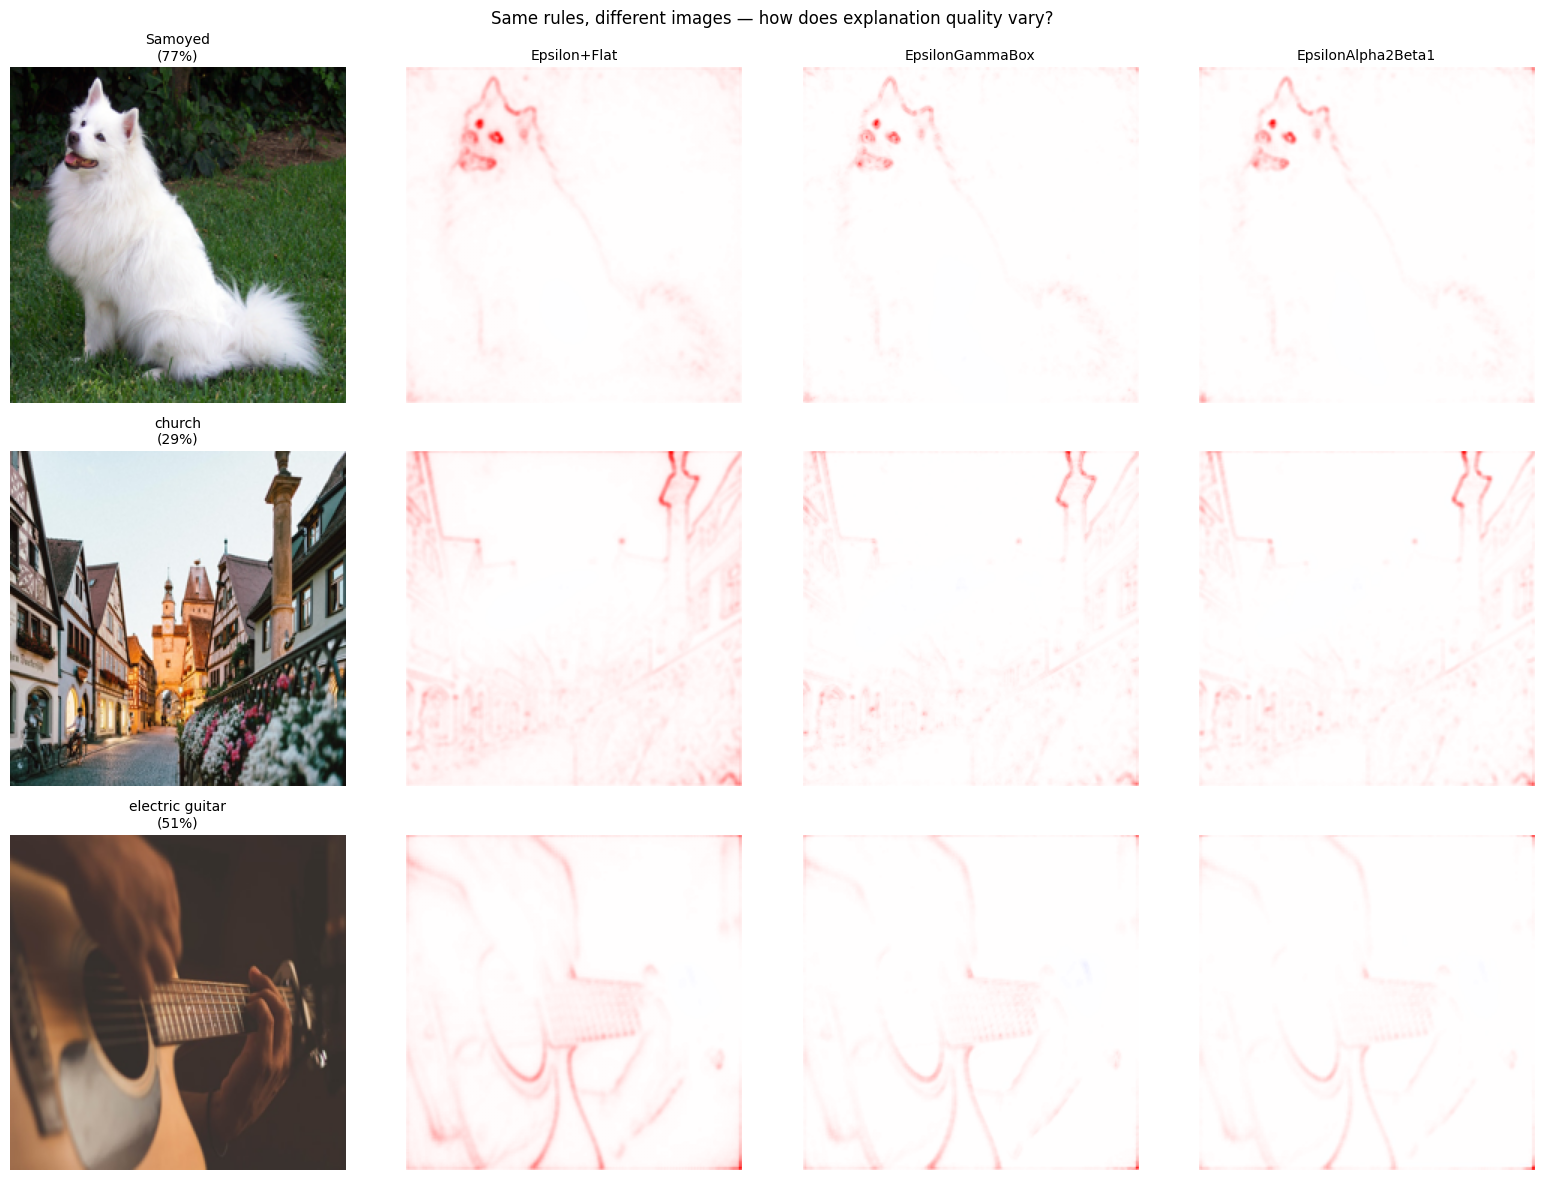

In [2]:
# Apply LRP with three different composite rules to each image
# Each decomposes relevance differently — producing visually distinct explanations
composites = {
    "Epsilon+Flat": EpsilonPlusFlat(),
    "EpsilonGammaBox": EpsilonGammaBox(low=-3.0, high=3.0),
    "EpsilonAlpha2Beta1": EpsilonAlpha2Beta1Flat(),
}

all_heatmaps = {}  # {img_name: {rule_name: hmap}}

for img_name, img in images.items():
    input_tensor = preprocess(img).unsqueeze(0).requires_grad_(True)
    target = torch.eye(1000)[[predictions[img_name]["idx"]]]
    heatmaps = {}

    for rule_name, composite in composites.items():
        with Gradient(model=model, composite=composite) as attributor:
            _, relevance = attributor(input_tensor, target)
        heatmaps[rule_name] = relevance.sum(1).squeeze().detach().cpu().numpy()

    all_heatmaps[img_name] = heatmaps

# Visualize: one row per image (original + 3 heatmaps)
fig, axes = plt.subplots(len(images), 4, figsize=(16, 4 * len(images)))

for row, (img_name, img) in enumerate(images.items()):
    pred = predictions[img_name]
    axes[row, 0].imshow(img)
    axes[row, 0].set_title(f"{pred['label']}\n({pred['confidence']:.0%})", fontsize=10)
    axes[row, 0].axis("off")

    for col, (rule_name, hmap) in enumerate(all_heatmaps[img_name].items()):
        vmax = max(abs(hmap.min()), abs(hmap.max()))
        axes[row, col + 1].imshow(hmap, cmap="bwr", vmin=-vmax, vmax=vmax, interpolation="bilinear")
        axes[row, col + 1].set_title(rule_name if row == 0 else "", fontsize=10)
        axes[row, col + 1].axis("off")

plt.suptitle("Same rules, different images — how does explanation quality vary?", fontsize=12)
plt.tight_layout()
plt.show()

## Evaluating Through the CUE Lens

The CUE model (Labarta et al., 2025) decomposes explanation understanding into three cognitive stages. Below I use simple perceptual proxies to approximate each stage — these are rough heuristics, not rigorous CUE measurements, but they help structure the comparison:

| CUE Stage | Question | Proxy Metric | Limitation |
|-----------|----------|--------------|------------|
| **Legibility** | Can you *see* the signal? | Signal-to-noise ratio (top attribution vs. background) | Doesn't account for colormap perception or visual acuity |
| **Readability** | Can you *parse* the structure? | Spatial coherence — Moran's I (are high-relevance pixels grouped?) | Ignores semantic grouping (a scattered but meaningful pattern scores low) |
| **Interpretability** | Can you *derive meaning*? | Focus (what fraction of relevance concentrates in the top 10%?) | Equates "focused" with "meaningful" — a strong assumption |

In [ ]:
def legibility(hmap, pct=75):
    """
    Legibility: "Can you *see* the signal?" (CUE Stage 1)

    This asks, "Is there a clear difference between 'important' and 'unimportant' spots in the heatmap, or is it just mush?"
    - We take the loudest (top X%) pixels as 'signal', and the rest as 'background noise'.
    - Output is like a signal-to-noise ratio: bigger means you can easily spot what's relevant.

    Limitations: Depends on colormap, actual human perception is more complex.
    """
    abs_hmap = np.abs(hmap)
    threshold = np.percentile(abs_hmap, pct)
    signal = abs_hmap[abs_hmap >= threshold].mean()
    noise_std = abs_hmap[abs_hmap < threshold].std()
    return float(signal / (noise_std + 1e-8))

def readability(hmap, step=2):
    """
    Readability: "Can you *parse* the structure?" (CUE Stage 2)

    Looks for clumps! If high values are grouped together, it's easier to spot shapes or patterns—like letters written with bright markers vs. random specks.
    - We check, for nearby pixels, if they're similar to each other.
    - Measurement is inspired by Moran's I: higher = more spatial grouping.

    Limitations: Only checks local grouping, ignores if the "clumps" themselves make semantic sense.
    """
    a = np.abs(hmap[::step, ::step])
    mean_a = a.mean()
    denom = np.sum((a - mean_a) ** 2)
    if denom == 0: return 0.0
    num = 0.0
    pairs = 0
    for dy, dx in [(0, 1), (1, 0)]:  # right & below neighbors
        s = np.roll(a, -1, axis=0 if dy else 1)
        v = (slice(None, -1), slice(None)) if dy else (slice(None), slice(None, -1))
        num += np.sum((a[v] - mean_a) * (s[v] - mean_a))
        pairs += a[v].size
    return float((a.size / pairs) * (num / denom))

def interpretability(hmap, top_frac=0.1):
    """
    Interpretability: "Can you *derive meaning*?" (CUE Stage 3)

    Measures how 'focused' the heatmap is—does it spotlight a small zone, or spread attention everywhere?
    - Imagine you kept only the brightest X% pixels: does that reveal most of the heat's total?
    - Higher = more explanation packed into a few spots (sparse focus).

    Limitations: Just being focused doesn't guarantee it's meaningful—sometimes, true "meaning" is spread out!
    """
    abs_hmap = np.abs(hmap).flatten()
    sorted_vals = np.sort(abs_hmap)[::-1]
    n_top = max(1, int(len(sorted_vals) * top_frac))
    return float(sorted_vals[:n_top].sum() / (sorted_vals.sum() + 1e-8))

# Score every heatmap with CUE-inspired metrics above
all_scores = {}  # {img_name: {rule_name: {dim: val}}}
for img_name, heatmaps in all_heatmaps.items():
    scores = {}
    for rule_name, hmap in heatmaps.items():
        scores[rule_name] = {
            "Legibility": legibility(hmap),
            "Readability": readability(hmap),
            "Interpretability": interpretability(hmap),
        }
    # Normalize each dimension to [0, 1] across the three rules (per image)
    for dim in ["Legibility", "Readability", "Interpretability"]:
        vals = [scores[n][dim] for n in heatmaps]
        lo, hi = min(vals), max(vals)
        for n in heatmaps:
            scores[n][dim] = (scores[n][dim] - lo) / (hi - lo + 1e-8)
    all_scores[img_name] = scores

# Summary table
print(f"\n{'Image':<10} {'Rule':<25} {'Legibility':>12} {'Readability':>12} {'Interpret.':>12}")
print("-" * 73)
for img_name in images:
    for rule_name in composites:
        s = all_scores[img_name][rule_name]
        print(f"{img_name:<10} {rule_name:<25} {s['Legibility']:>12.2f} {s['Readability']:>12.2f} {s['Interpretability']:>12.2f}")

## A Second Lens: Vision Model Commentary

The proxy metrics measure signal properties. As an experiment, I also ran a small vision-language model (moondream2, ~2B params) on each heatmap to get a more "cognitive" read — closer to how a human might respond, though still far from a real user study.

> **Colab tip:** Select *Runtime → Change runtime type → T4 GPU* for faster VLM inference (~10× vs CPU).

In [ ]:
# A lightweight vision-language model comments on each heatmap's CUE qualities.
# moondream2 (~2B params) — uses GPU on Colab, falls back to CPU locally.
for pkg in ["transformers", "einops"]:
    try: __import__(pkg)
    except ImportError: subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

from transformers import AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

model_id = "vikhyatk/moondream2"
revision = "2025-01-09"  # pin for reproducibility — API changed between 2024/2025
print(f"Loading {model_id} (rev {revision}) on {device}...")
vlm = AutoModelForCausalLM.from_pretrained(
    model_id, revision=revision, trust_remote_code=True,
    dtype=dtype, device_map={"": device}
)

def side_by_side(original, hmap):
    """Create original|heatmap composite so the VLM sees both."""
    vmax = max(abs(hmap.min()), abs(hmap.max()))
    fig, ax = plt.subplots(figsize=(2.24, 2.24), dpi=100)
    ax.imshow(hmap, cmap="bwr", vmin=-vmax, vmax=vmax, interpolation="bilinear")
    ax.axis("off")
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    buf = io.BytesIO()
    fig.savefig(buf, format="PNG", bbox_inches="tight", pad_inches=0)
    plt.close(fig)
    buf.seek(0)
    hmap_pil = Image.open(buf).convert("RGB").resize(original.size)
    comp = Image.new("RGB", (original.size[0] * 2, original.size[1]))
    comp.paste(original, (0, 0))
    comp.paste(hmap_pil, (original.size[0], 0))
    return comp

vlm_commentary = {}
for img_name in images:
    pred = predictions[img_name]
    vlm_commentary[img_name] = {}
    print(f"\n{'='*60}")
    print(f"  {img_name}: {pred['label']} ({pred['confidence']:.0%})")
    print(f"{'='*60}")

    for rule_name, hmap in all_heatmaps[img_name].items():
        comp = side_by_side(images[img_name], hmap)
        result = vlm.query(comp, (
            f"Left: an image classified as '{pred['label']}'. "
            f"Right: its LRP heatmap (red = supports prediction, blue = contradicts). "
            f"Briefly: (1) Is the signal clearly visible against the background? "
            f"(2) Are highlighted regions spatially grouped? "
            f"(3) Does the focus make sense for '{pred['label']}'?"
        ))
        answer = result["answer"]
        vlm_commentary[img_name][rule_name] = answer
        print(f"\n  {rule_name}:\n    {answer}")

print(f"\n(Commentary from moondream2 — a rough 'cognitive' proxy, not a human study.)")

## Reflection

The same prediction explained three ways — and each *feels* different to look at. The CUE model's insight is that this isn't cosmetic: it shapes whether someone actually understands what the network is doing.

*Built with [zennit](https://github.com/chr5tphr/zennit) (Fraunhofer HHI) · Vincent Lange · vincentelange@gmail.com*